# TABLE OF CONTENTS:
---
* [Setup](#Setup)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Data](#Data)
    * [Download Data](#Download-Data)
    * [Explore Data](#Explore-Data)
    * [Upload Data](#Upload-Data)
    * [Create and Register AML Datasets](#Create-and-Register-AML-Datasets)
* [Compute Target](#Compute-Target)
* [Training Artifacts](#Training-Artifacts)
* [Training Environment](#Development-Environment)
* [Compute Target](#Compute-Target)
* [Development Environment](#Development-Environment)
* [Experiment & Run Configuration](#Experiment-&-Run-Configuration)
    * [Option 1: Normal Script Run](#Option-1:-Normal-Script-Run)
    * [Option 2: Hyperdrive Run](#Option-2:-Hyperdrive-Run)
* [Model Registration](#Model-Registration)
    * [Model Download](#Model-Download)
* [Resource Clean Up](#Resource-Clean-Up)
---

# Setup

Append parent directory to sys path to be able to import modules from src directory.

In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

In [2]:
# Import libraries and modules
import azureml.core
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import scipy.io
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import uuid

from azureml.core.authentication import MsiAuthentication
from azureml.core import Dataset, Environment, Experiment, Keyvault, Model, ScriptRunConfig, Workspace
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import InferenceConfig 
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform
from azureml.widgets import RunDetails
from torchvision import datasets

from src.training.data_utils import load_data, show_image
from src.training.download_utils import download_file, extract_stanford_dogs_archive

print(f"azureml.core version: {azureml.core.VERSION}")

azureml.core version: 1.19.0


Automatically reload modules when changes are made.

In [3]:
%load_ext autoreload
%autoreload 2

Create a training directory. This directory will contain all artifacts needed for model training. For AML remote training this directory will be copied to the remote compute at runtime.

In [4]:
training_folder = os.path.join(os.getcwd(), "../src/training")
os.makedirs(training_folder, exist_ok=True)
print(f"Training folder {training_folder} has been created.")

Training folder /mnt/batch/tasks/shared/LS_root/mounts/clusters/amlbriksevnetci/code/Users/BRIKSE/pytorch-use-cases-azure-ml/image_classification_template_project/notebooks/../src/training has been created.


Create a directory to store all data.

In [5]:
data_folder = os.path.join(os.getcwd(), "../data")
os.makedirs(data_folder, exist_ok=True)
print(f"Data folder {data_folder} has been created.")

Data folder /mnt/batch/tasks/shared/LS_root/mounts/clusters/amlbriksevnetci/code/Users/BRIKSE/pytorch-use-cases-azure-ml/image_classification_template_project/notebooks/../data has been created.


### Connect to Workspace

In order to connect and communicate with the Azure Machine Learning (AML) workspace, a workspace object needs to be instantiated using the Azure ML SDK.

In [6]:
# Connect to the AML workspace. MsiAuthenthication only works out of the box on the AML Compute Instance.
# For alternative connection options see the aml_snippets directory.
msi_auth = MsiAuthentication()

ws = Workspace(subscription_id="bf088f59-f015-4332-bd36-54b988be7c90",
               resource_group="amlbrikserg",
               workspace_name="amlbriksews",
               auth=msi_auth)

# Data

For this template, the CIFAR-10 image dataset is used for multiclass classification. It has the classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The images in CIFAR-10 are three-channel color images of 32x32 pixels in size.

### Download Data

Use the Pytorch dataset and dataloader classes to download the CIFAR-10 data to the AML Compute Instance / local compute.

In [7]:
# Define transformation steps
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, variance of channels

# Create train dataset and dataloader
trainset = torchvision.datasets.CIFAR10(root="../data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Create test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root="../data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Define classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


### Explore Data

Display the first batch of 4 images.

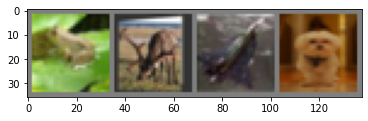

      frog       deer      plane        dog


In [8]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose dimensions from Pytorch format to default numpy format
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(" ".join("%10s" % classes[labels[j]] for j in range(4)))

### Upload Data

Upload the data to the default AML datastore.

In [9]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir="../data", target_path="data/cifar-10", overwrite=True)

Uploading an estimated of 9 files
Uploading ../data/cifar-10-batches-py/batches.meta
Uploaded ../data/cifar-10-batches-py/batches.meta, 1 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/readme.html
Uploaded ../data/cifar-10-batches-py/readme.html, 2 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/test_batch
Uploaded ../data/cifar-10-batches-py/test_batch, 3 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_1
Uploaded ../data/cifar-10-batches-py/data_batch_1, 4 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_2
Uploaded ../data/cifar-10-batches-py/data_batch_2, 5 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_3
Uploaded ../data/cifar-10-batches-py/data_batch_3, 6 files out of an estimated total of 9
Uploading ../data/cifar-10-batches-py/data_batch_5
Uploaded ../data/cifar-10-batches-py/data_batch_5, 7 files out of an estima

$AZUREML_DATAREFERENCE_85844902e74f4963bf00e7b2cc1aacf7

### Create and Register AML Datasets

Register the data as a dataset in the AML workspace.

In [10]:
# Create a dataset object from datastore location
dataset = Dataset.File.from_files(path=(datastore, "data/cifar-10"))

In [11]:
# Register the dataset
dataset = dataset.register(workspace=ws,
                           name="cifar-10-dataset",
                           description="cifar-10 training dataset",
                           create_new_version=True)

# Compute Target

Create a remote compute target to run experiments on. The below code will first check whether a compute target with name `cluster_name` already exists and if it does, it will use that instead of creating a new one.

In [12]:
# Choose a name for the CPU cluster
cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2", # CPU
                                                           # vm_size='STANDARD_NC6', # GPU
                                                           max_nodes=4,
                                                           idle_seconds_before_scaledown=2400)
    
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

# Use get_status() to get a detailed status for the current cluster
print(compute_target.get_status().serialize())

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-01-18T15:17:11.553000+00:00', 'errors': None, 'creationTime': '2021-01-15T09:55:01.226729+00:00', 'modifiedTime': '2021-01-15T09:55:16.691497+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT2400S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


# Training Artifacts

A training script is created in the aml_training folder. This script will be executed by the remote compute.

In [13]:
%%writefile $training_folder/train.py
import os
import argparse
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core import Run
from model import Net


run = Run.get_context()

if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_path", type=str, help="Path to the training data")
    parser.add_argument("--learning_rate", type=float, default=0.01, help="Learning rate for SGD")
    parser.add_argument("--momentum", type=float, default=0.9,help="Momentum for SGD")

    args = parser.parse_args()

    print("")
    print("========== DATA ==========")
    print("Data Location: " + args.data_path)
    print("Available Files:", os.listdir(args.data_path))
    print("==========================")
    print("")

    # Create dataloader for CIFAR-10 training data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = torchvision.datasets.CIFAR10(root=args.data_path, train=True, 
                                            download=False, transform=transform)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=2)

    # Leverage GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Define convolutional network
    net = Net()
    net.to(device)

    # Set up pytorch cross entropy loss and SGD optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=args.momentum)

    print("===== MODEL TRAINING =====")
    
    # Train the network
    for epoch in range(2):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Unpack the data
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad() # zero the parameter gradients

            # Run forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                loss = running_loss / 2000
                run.log("loss", loss) # log loss metric to AML
                print(f"epoch={epoch + 1}, batch={i + 1:5}: loss {loss:.2f}")
                running_loss = 0.0

    print("Finished training")
    print("==========================")
    print("")
    
    os.makedirs("outputs", exist_ok=True)
    file_path = "outputs/cifar_net.pt"
    torch.save(net.state_dict(), file_path) # Anything written to the outputs folder on remote compute is automatically uploaded to the run outputs 
    # run.upload_file(name=file_path, path_or_stream=file_path)
    
    print("Saved and uploaded model")

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/amlbriksevnetci/code/Users/BRIKSE/pytorch-use-cases-azure-ml/image_classification_template_project/notebooks/../src/training/train.py


Create a model file which contains the network architecture.

In [14]:
%%writefile $training_folder/model.py
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/amlbriksevnetci/code/Users/BRIKSE/pytorch-use-cases-azure-ml/image_classification_template_project/notebooks/../src/training/model.py


Run the training script locally for 1 epoch for debugging purposes.

In [15]:
!python ../src/training/train.py --data_path ../data --learning_rate 0.003 --momentum 0.9


========== DATA ==========
Data Location: ../data
Available Files: ['cifar-10-batches-py', 'cifar-10-python.tar.gz']

===== MODEL TRAINING =====
Attempted to log scalar metric loss:
2.018660556346178
epoch=1, batch= 2000: loss 2.02
Attempted to log scalar metric loss:
1.7054529407918453
epoch=1, batch= 4000: loss 1.71
Attempted to log scalar metric loss:
1.6093946214020252
epoch=1, batch= 6000: loss 1.61
Attempted to log scalar metric loss:
1.5390797355473043
epoch=1, batch= 8000: loss 1.54
Attempted to log scalar metric loss:
1.5291588851213456
epoch=1, batch=10000: loss 1.53
Attempted to log scalar metric loss:
1.509649636529386
epoch=1, batch=12000: loss 1.51
Attempted to log scalar metric loss:
1.419863632209599
epoch=2, batch= 2000: loss 1.42
Attempted to log scalar metric loss:
1.4320571963079274
epoch=2, batch= 4000: loss 1.43
Attempted to log scalar metric loss:
1.4130413945093752
epoch=2, batch= 6000: loss 1.41
Attempted to log scalar metric loss:
1.4225672216359526
epoch=2, 

# Training Environment

Load the environment that has been registered as part of the **01_environment_creation** notebook and use it for remote training.

In [16]:
env_name = "pytorch-aml-env"
env = Environment.get(workspace=ws, name=env_name)

# Experiment & Run Configuration

Now that the training artifacts are prepared, a model can be trained on the remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time. 

### Option 1: Normal Script Run

In [17]:
# Create the experiment
experiment = Experiment(workspace=ws, 
                        name="cifar-image-classification-pytorch")

# Create the script run configuration
config = ScriptRunConfig(source_directory="../src/training",
                         script="train.py",
                         compute_target=compute_target,
                         arguments=[
                             "--data_path", dataset.as_named_input("input").as_mount(),
                             "--learning_rate", 0.003,
                             "--momentum", 0.92])

config.run_config.environment = env

# Submit the run
run = experiment.submit(config)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Option 2: Hyperdrive Run

WORK IN PROGRESS!!!

Hyperparameters can be tuned using AML's hyperdrive capability.

The initial learning rate is tuned. The training script uses a LR schedule to decay the learning rate every several epochs starting from that initial learning rate.

Random sampling is used to try different configuration sets of hyperparameters to maximize the primary metric, the best validation accuracy (best_val_acc).

An early termination policy is specified to early terminate poorly performing runs. The BanditPolicy is used, which will terminate any run that doesn't fall within the slack factor of the primary evaluation metric. In this tutorial, this policy will be applied every epoch (since the best_val_acc metric is reported every epoch and evaluation_interval=1). The first policy evaluation will be delayed until after the first 10 epochs (delay_evaluation=10). 

In [ ]:
param_sampling = RandomParameterSampling({
        "num_epochs": choice(10,15,20),
        "learning_rate": uniform(0.0005, 0.005), 
        "momentum": uniform(0.9, 0.99),
    }
)

early_termination_policy = BanditPolicy(slack_factor=0.15, evaluation_interval=1, delay_evaluation=10)

hyperdrive_config = HyperDriveConfig(run_config=config,
                                     hyperparameter_sampling=param_sampling, 
                                     policy=early_termination_policy,
                                     primary_metric_name="best_val_acc",
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                     max_total_runs=8,
                                     max_concurrent_runs=4)

In [ ]:
# Start the HyperDrive run
hyperdrive_run = experiment.submit(hyperdrive_config)

In [ ]:

RunDetails(hyperdrive_run).show()

...........

In [18]:
# Get portal URL
run.get_portal_url()

'https://ml.azure.com/experiments/cifar-image-classification-pytorch/runs/cifar-image-classification-pytorch_1611584664_d4c099a6?wsid=/subscriptions/bf088f59-f015-4332-bd36-54b988be7c90/resourcegroups/amlbrikserg/workspaces/amlbriksews'

In [19]:
run.wait_for_completion(show_output=False)

{'runId': 'cifar-image-classification-pytorch_1611584664_d4c099a6',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-01-25T14:27:11.36462Z',
 'endTimeUtc': '2021-01-25T14:36:12.00686Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'c86678b4-4bc9-4521-ad78-924b689c3e6a',
  'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml',
  'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': 'd1d1fdf81fa79712347b61f0282dde7b6ca1eb7c',
  'mlflow.source.git.commit': 'd1d1fdf81fa79712347b61f0282dde7b6ca1eb7c',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '61642a3e-719f-4c24-8878-a9a7c05fc0b5'}, 'consumptionDetails': {'type': 'RunIn

In [24]:
# Check run metrics, details and file names
print(run.get_metrics())
print("==========================")
print(run.get_details())
print("==========================")
print(run.get_file_names())

{'loss': [2.049492015570402, 1.7161528019309045, 1.6128060222230851, 1.5635809588730336, 1.5200882316678763, 1.5095152949616313, 1.4630293169617652, 1.4621588141471147, 1.45472626234591, 1.4551975659839809, 1.457462860453874, 1.4396130393967033]}
{'runId': 'cifar-image-classification-pytorch_1611584664_d4c099a6', 'target': 'cpu-cluster', 'status': 'Completed', 'startTimeUtc': '2021-01-25T14:27:11.36462Z', 'endTimeUtc': '2021-01-25T14:36:12.00686Z', 'properties': {'_azureml.ComputeTargetType': 'amlcompute', 'ContentSnapshotId': 'c86678b4-4bc9-4521-ad78-924b689c3e6a', 'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml', 'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': 'd1d1fdf81fa79712347b61f0282dde7b6ca1eb7c', 'mlflow.source.git.commit': 'd1d1fdf81fa79712347b61f0282dde7b6ca1eb7c', 'azureml.git.dirty': 'True', 'Proc

# Model Registration

In [25]:
model_path = "outputs/cifar_net.pt"

model = run.register_model(model_name="cifar10-model",
                           model_path=model_path,
                           model_framework=Model.Framework.PYTORCH,
                           description="cifar10 model")

print(model.name, model.id, model.version, sep="\t")

cifar10-model	cifar10-model:2	2


### Model Download

In [28]:
download_model=True

if download_model:
    
    # Create directory
    outputs_folder = os.path.join(os.getcwd(), "../outputs")
    os.makedirs(outputs_folder, exist_ok=True)
    print(f"Outputs folder {outputs_folder} has been created.")
    
    # Download model artifact
    run.download_file(name=model_path, output_file_path="../outputs/cifar_net.pt")

Outputs folder /mnt/batch/tasks/shared/LS_root/mounts/clusters/amlbriksevnetci/code/Users/BRIKSE/pytorch-use-cases-azure-ml/image_classification_template_project/notebooks/../outputs has been created.


# Resource Clean Up

In [29]:
compute_target.delete()

Current provisioning state of AmlCompute is "Deleting"

